# Identifying Duplicate Questions

Welcome to the Quora Question Pairs competition! Here, our goal is to identify which questions asked on [Quora](https://www.quora.com/), a quasi-forum website with over 100 million visitors a month, are duplicates of questions that have already been asked. This could be useful, for example, to instantly provide answers to questions that have already been answered. We are tasked with predicting whether a pair of questions are duplicates or not, and submitting a binary prediction against the logloss metric.

If you have any questions or want to discuss competitions/hardware/games/anything with other Kagglers, then join the KaggleNoobs Slack channel [here](https://goo.gl/gGWFXe). We also have regular AMAs with top Kagglers there.

**And as always, if this helped you, some upvotes would be very much appreciated - that's where I get my motivation! :D**

Let's dive right into the data!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

# print('# File sizes')
# for f in os.listdir('../input'):
#     if 'zip' not in f:
#         print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

Looks like we are simply given two files this time round, one for the training set and one for the test set. They are relatively small compared to other recent competitions, weighing in at less than 400MB total.

It's worth noting that there is a lot more testing data than training data. This could be a sign that some of the test data is dummy data designed to deter hand-labelling, and not included in the calculations, like we recently saw in the [DSTL competition](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/leaderboard).

Let's open up one of the datasets.

## Training set

In [3]:
df_train = pd.read_csv('armath.tsv',sep='\t')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,1,16020,16025,Equivalent statements of the Axiom of Choice. ...,Assume the first form. Let I be any set and le...,0
1,2,16020,697264,Equivalent statements of the Axiom of Choice. ...,I know two equivalent definitions for an onto ...,0
2,3,16020,2645743,Equivalent statements of the Axiom of Choice. ...,This is part of the all-important Corresponden...,0
3,4,16020,2875568,Equivalent statements of the Axiom of Choice. ...,I am going to answer my own question. I had a ...,0
4,5,16020,1650515,Equivalent statements of the Axiom of Choice. ...,"More informally, elements of the free semigrou...",0


We are given a minimal number of data fields here, consisting of:

**`id`:** Looks like a simple rowID    
**`qid{1, 2}`:** The unique ID of each question in the pair    
**`question{1, 2}`:** The actual textual contents of the questions.    
**`is_duplicate`:** The **label** that we are trying to predict - whether the two questions are duplicates of each other.

Total number of question pairs for training: 42295
Duplicate pairs: 9.09%
Total number of questions in the training data: 42793
Number of questions that appear multiple times: 6742



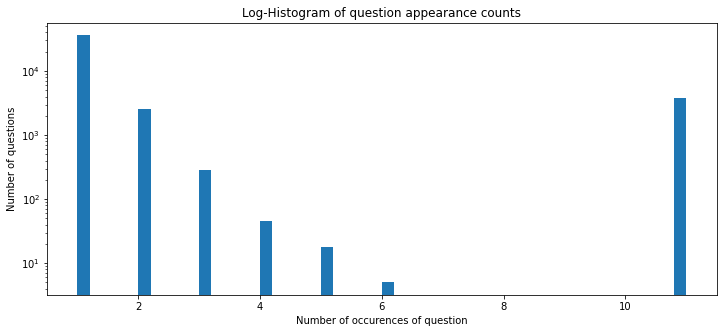

In [4]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In terms of questions, everything looks as I would expect here. Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

We can see that we have a 37% positive class in this dataset. Since we are using the [LogLoss](https://www.kaggle.com/wiki/LogarithmicLoss) metric, and LogLoss looks at the actual predicts as opposed to the order of predictions, we should be able to get a decent score by creating a submission predicting the mean value of the label.



## Text analysis

First off, some quick histograms to understand what we're looking at. **Most analysis here will be only on the training set, to avoid the auto-generated questions**

mean-train 621.50 std-train 255.42  max-train 9878.00 


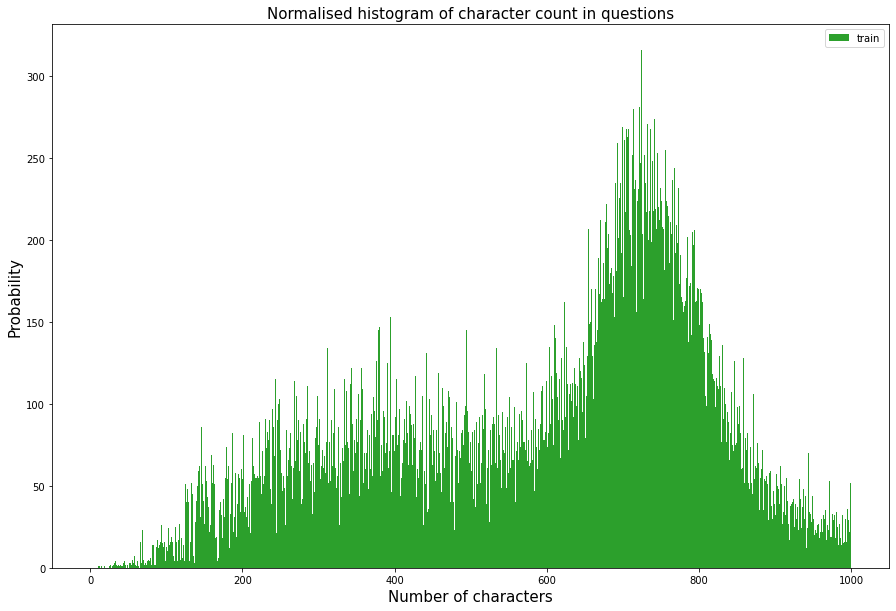

In [9]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
# test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
# dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=1000, range=[0, 1000], color=pal[2], label='train')
# plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f}  max-train {:.2f} '.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 102.15 std-train 35.15  max-train 809.00 


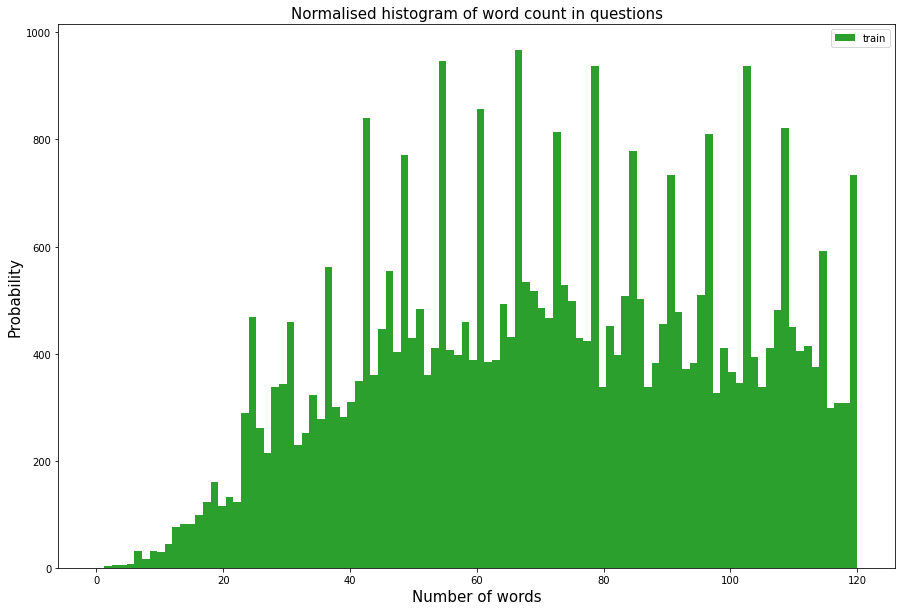

In [17]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))


plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=100, range=[0, 120], color=pal[2], label='train')

plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f}  max-train {:.2f} '.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

## Semantic Analysis

Next, I will take a look at usage of different punctuation in questions - this may form a basis for some interesting features later on.

In [10]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

Text(0.5, 0, 'word_match_share')

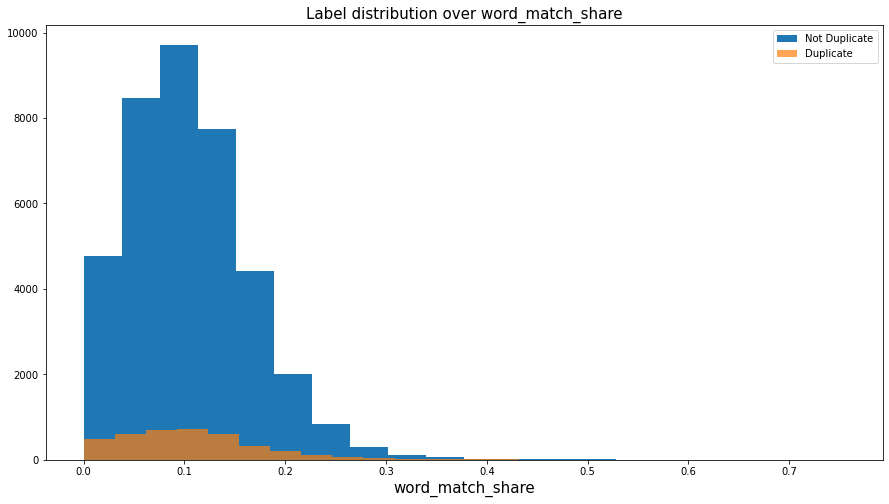

In [19]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 8))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20,  label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20,  alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

You may want to look into using sklearn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute weights if you are implementing this yourself, but as I am too lazy to read the documentation I will write a version in pure python with a few changes which I believe should help the score.

In [20]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [21]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.4869435463814973e-06), ('of', 4.209516031941808e-06), ('is', 4.223026474152967e-06), ('a', 4.4047430272917875e-06), ('to', 5.917930144752572e-06), ('and', 6.366628679115548e-06), ('that', 7.276961141027507e-06), ('i', 8.674155354122392e-06), ('in', 9.099595068019473e-06), ('=', 9.362857544122466e-06)]

Least common words and weights: 


[('h(i).', 9.998000399920016e-05),
 ('i,g(i)\\rangle\\in', 9.998000399920016e-05),
 ('all-important', 9.998000399920016e-05),
 ('i\\;', 9.998000399920016e-05),
 ('u\\setminus\\left\\{', 9.998000399920016e-05),
 ('\\varnothing\\right\\}', 9.998000399920016e-05),
 ('r^{-}\\left[m\\right]=\\varnothing,', 9.998000399920016e-05),
 ('r-first', 9.998000399920016e-05),
 ('r^{-}\\left[x\\right]:=\\left\\{', 9.998000399920016e-05),
 ('zrx\\right\\}', 9.998000399920016e-05)]

In [22]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

Text(0.5, 0, 'word_match_share')

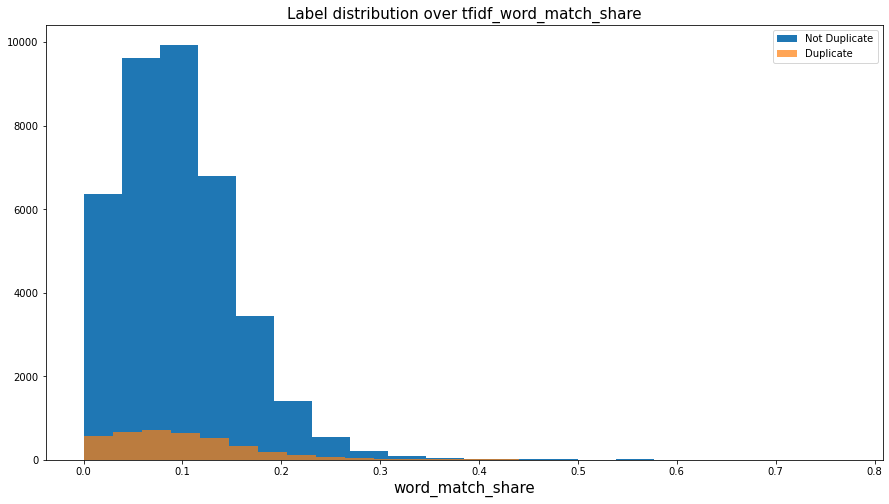

In [26]:
plt.figure(figsize=(15, 8))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20,  label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20,  alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [25]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.4947087176868276
   TFIDF AUC: 0.495526083052484


So it looks like our TF-IDF actually got better in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction. For this, I will use our old friend XGBoost to make a classification model.

## Rebalancing the Data
However, before I do this, I would like to rebalance the data that XGBoost receives, since we have 37% positive class in our training data, and only 17% in the test data. By re-balancing the data so our training set has 17% positives, we can ensure that XGBoost outputs probabilities that will better match the data on the leaderboard, and should get a better score (since LogLoss looks at the probabilities themselves and not just the order of the predictions like AUC)

In [28]:
# First we create our training and testing data
x_train = pd.DataFrame()
# x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
# x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
# x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

In [18]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [35]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [37]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.67979	valid-logloss:0.67995
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.57115	valid-logloss:0.57280
[20]	train-logloss:0.49549	valid-logloss:0.49845
[30]	train-logloss:0.44147	valid-logloss:0.44560
[40]	train-logloss:0.40236	valid-logloss:0.40754
[50]	train-logloss:0.37383	valid-logloss:0.37996
[60]	train-logloss:0.35296	valid-logloss:0.35993
[70]	train-logloss:0.33770	valid-logloss:0.34545
[80]	train-logloss:0.32659	valid-logloss:0.33502
[90]	train-logloss:0.31851	valid-logloss:0.32758
[100]	train-logloss:0.31267	valid-logloss:0.32231
[110]	train-logloss:0.30847	valid-logloss:0.31862
[120]	train-logloss:0.30542	valid-logloss:0.31609
[130]	train-logloss:0.30316	valid-logloss:0.31439
[140]	train-logloss:0.30157	valid-logloss:0.31323
[150]	train-logloss:0.30043	valid-logloss:0.31244
[160]	train-logloss:0.29956	valid-logloss:0.31194
[170]	trai

In [21]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

**0.35460** on the leaderboard - a good first score!